In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import warnings
import spacy
from anchor import anchor_text
import pickle
import torch
from myUtils import *
from triggers.model_loader import load_model
from triggers.data_utils import *

SEED = 84
torch.manual_seed(SEED)
warnings.simplefilter("ignore")

/home/almr16/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/allennlp/tango/__init__.py:17: UserWarning: AllenNLP Tango is an experimental API and parts of it might change or disappear every time we release a new version.
  warnings.warn(


In [2]:
plt.rcParams['font.size'] = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
model, vocab = load_model()

building vocab:   0%|          | 0/98794 [00:00<?, ?it/s]

In [4]:
dev, dev_labels = get_dev_sst()

In [4]:
from allennlp.data.tokenizers.spacy_tokenizer import SpacyTokenizer as Tokenizer
from allennlp.data.data_loaders.simple_data_loader import SimpleDataLoader
from allennlp.nn.util import move_to_device

t = Tokenizer()

In [5]:
def predict_sentences(sentences):
    sentences = [create_instance(s,t) for s in sentences]
    iterator = SimpleDataLoader(sentences, batch_size = len(sentences))
    iterator.index_with(vocab)
    
    input_tokens = list(iterator)[0]['tokens']
    input_tokens = move_to_device(input_tokens, device=0)
    
    output = model(input_tokens)
    return torch.argmax(output, dim=1).cpu().numpy()

In [7]:
predict_sentences(["good"])

array([0])

In [8]:
len([dev_x for dev_x in dev if 80>len(dev_x) > 15])

283

# Prediction is opposite to label!!

# Anchor Part

In [6]:
nlp = spacy.load('en_core_web_sm')

In [7]:
explainer = anchor_text.AnchorText(nlp, ['positive', 'negative'], use_unk_distribution=False)

In [11]:
anchor_examples = [example for example in dev if len(example) < 100 and len(example)>15]

In [12]:
pickle.dump( anchor_examples, open( "results/trigger_anchor_examples.pickle", "wb" ))

In [21]:
pickle.dump( test, open( "results/trigger_test.pickle", "wb" ))
pickle.dump( test_labels, open( "results/trigger_test_labels.pickle", "wb" ))

In [ ]:
my_utils = TextUtils(anchor_examples, dev, explainer, predict_sentences, "results/trigger_exps.pickle")
explanations = my_utils.compute_explanations(list(range(len(anchor_examples))))

In [ ]:
pickle.dump( explanations, open( "results/trigger_exps_list.pickle", "wb" ))

# Loading Results

In [8]:
test = pickle.load( open( "results/trigger_test.pickle", "rb" ))
test_labels = pickle.load( open( "results/trigger_test_labels.pickle", "rb" ))
test_labels = np.array(test_labels)
explanations  = pickle.load(open( "results/trigger_exps_list.pickle", "rb" ))

In [30]:
test_prediction = predict_sentences(test)
anchor_prediction = predict_sentences(anchor_examples)
pickle.dump( test_prediction, open( "results/trigger_test_prediction.pickle", "wb" ))
pickle.dump( anchor_prediction, open( "results/trigger_anchor_prediction.pickle", "wb" ))

In [9]:
len(explanations)

363

In [10]:
anchor_examples = pickle.load( open( "results/trigger_anchor_examples.pickle", "rb" ))

In [87]:
explanations = [ExtendedExplanation(exp, anchor_examples, test, test_labels, predict_sentences, explainer) for exp in explanations if len(exp.fit_examples) > 1]

In [88]:
pickle.dump( explanations, open( "results/trigger_extended_exps.pickle", "wb" ))

In [11]:
explanations = pickle.load(open( "results/trigger_extended_exps.pickle", "rb" ))

In [12]:
explanations = [exp for exp in explanations if len(exp.fit_examples) > 5] 
explanations.sort(key=lambda exp: exp.test_precision)

In [13]:
predict_sentences(['bad', 'good', 'pointless'])

array([1, 0, 1])

In [45]:
predict_sentences(test[best[3].fit_examples])

array([0, 1, 1, 1, 1, 1])

In [38]:
filtered = [exp for exp in explanations if len(' '.join(exp.names))>3]
best = filtered[-20:]
best.reverse()
for exp in best:
    print("------------------------")
    print(str(anchor_examples[exp.index]))
    exp_label =  predict_sentences([str(anchor_examples[exp.index])])[0]
    print('Prediction:', explainer.class_names[exp_label])
    print('Anchor: %s' % (' AND '.join(exp.names)))
    print('Precision: %.2f' % exp.precision)
    print('Coverage: %.2f' % exp.coverage)
    print('Anchor test precision: %.2f' % exp.test_precision)
    print('Anchor test coverage: %.2f' % (exp.test_cov))
    covered_labels = test_labels[exp.fit_examples]
    ##### the trained model has the opposite label
    real_percentage = 1- np.mean(covered_labels == exp_label)
    print('Anchor test REAL precision: %.2f' % real_percentage)
   

------------------------
it 's a beautiful madness .
Prediction: positive
Anchor: beautiful
Precision: 0.98
Coverage: 0.00
Anchor test precision: 1.00
Anchor test coverage: 0.01
Anchor test REAL precision: 1.00
------------------------
this is so bad .
Prediction: negative
Anchor: bad AND so
Precision: 0.97
Coverage: 0.00
Anchor test precision: 0.86
Anchor test coverage: 0.01
Anchor test REAL precision: 0.86
------------------------
not an objectionable or dull film ; it merely lacks everything except good intentions .
Prediction: negative
Anchor: lacks
Precision: 1.00
Coverage: 0.00
Anchor test precision: 0.86
Anchor test coverage: 0.01
Anchor test REAL precision: 0.86
------------------------
it 's a buggy drag .
Prediction: negative
Anchor: drag
Precision: 0.98
Coverage: 0.00
Anchor test precision: 0.83
Anchor test coverage: 0.01
Anchor test REAL precision: 0.67
------------------------
it 's slow -- very , very slow .
Prediction: negative
Anchor: slow
Precision: 0.98
Coverage: 1.00

In [103]:
exps = explanations

#trained model has the opposite label
real_precisions = [1- exp.real_precision for exp in exps]
test_precisions = [exp.test_precision for exp in exps]

In [105]:
!git checkout results/transformer.png

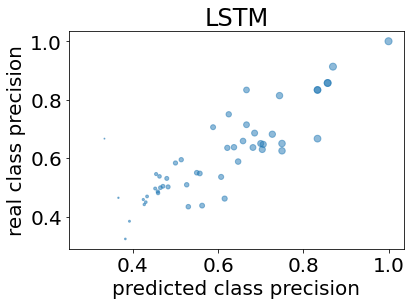

In [107]:
plt.scatter(test_precisions, real_precisions, s = range(len(exps)), alpha = 0.5)
plt.xlabel('predicted class precision')
plt.ylabel('real class precision')
plt.title('LSTM')
plt.savefig("results/trigger.png")

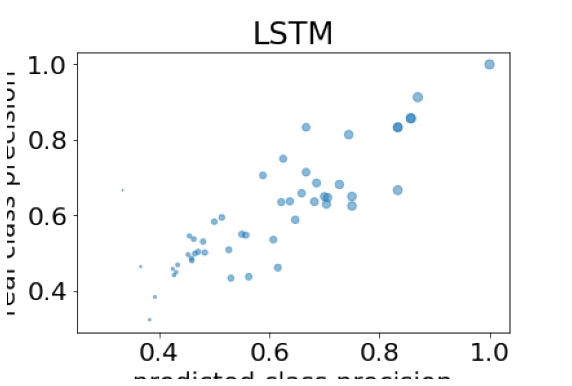

In [109]:
img = plt.imread("results/trigger.png")
plt.figure(figsize = (10,10))
plt.axis('off')
_ = plt.imshow(img)